In [1]:

import numpy as np # For numerical operations
import pandas as pd # For data manipulation and analysis
import matplotlib.pyplot as plt # For plotting and visualization
import seaborn as sns # For enhanced data visualization
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:
import yfinance as yf
from datetime import datetime

# Define the ticker symbol for Bitcoin and the date range
BITCOIN_TICKER = "BTC-USD"
START_DATE = "2014-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")

print(f"Fetching data for {BITCOIN_TICKER} from {START_DATE} to {END_DATE}...")
btc_data = yf.download(BITCOIN_TICKER, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)
initial_missing_count = btc_data.isnull().sum().sum()
if initial_missing_count > 0:
    print(f"Warning: Found {initial_missing_count} missing values. Handling them...")
    btc_data.dropna(inplace=True)
    print("Missing values handled by dropping rows with NaN.")
else:
    print("No missing values found in the downloaded data.")

# Display the first 5 rows of the DataFrame
print("\nFirst 5 rows of Bitcoin price data (Adjusted Close):")
print(btc_data.head())

# Display summary statistics of the DataFrame
print("\nSummary statistics of Bitcoin price data:")
print(btc_data.describe())

Fetching data for BTC-USD from 2014-01-01 to 2026-02-02...
No missing values found in the downloaded data.

First 5 rows of Bitcoin price data (Adjusted Close):
Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100

Summary statistics of Bitcoin price data:
Price           Close           High            Low           Open  \
Ticker        BTC-USD        BTC-USD        BTC-USD        BTC-USD   
count     4156.000000    4156.000000    4156.000000    4156.000000   
mean     27334.912268   27861.4211


Last 5 rows with computed metrics:
Price              Price Log_Return Cumulative_Simple_Return  Rolling_Peak  \
Ticker                                                                       
Date                                                                         
2026-01-28  89184.570312   0.000920               194.009703  124752.53125   
2026-01-29  84561.585938  -0.053228               183.901151  124752.53125   
2026-01-30  84128.656250  -0.005133               182.954514  124752.53125   
2026-01-31  78621.117188  -0.067707               170.911808  124752.53125   
2026-02-01  76974.445312  -0.021167               167.311219  124752.53125   

Price       Drawdown Is_Crash  
Ticker                         
Date                           
2026-01-28 -0.285108     True  
2026-01-29 -0.322165     True  
2026-01-30 -0.325636     True  
2026-01-31 -0.369783     True  
2026-02-01 -0.382983     True  


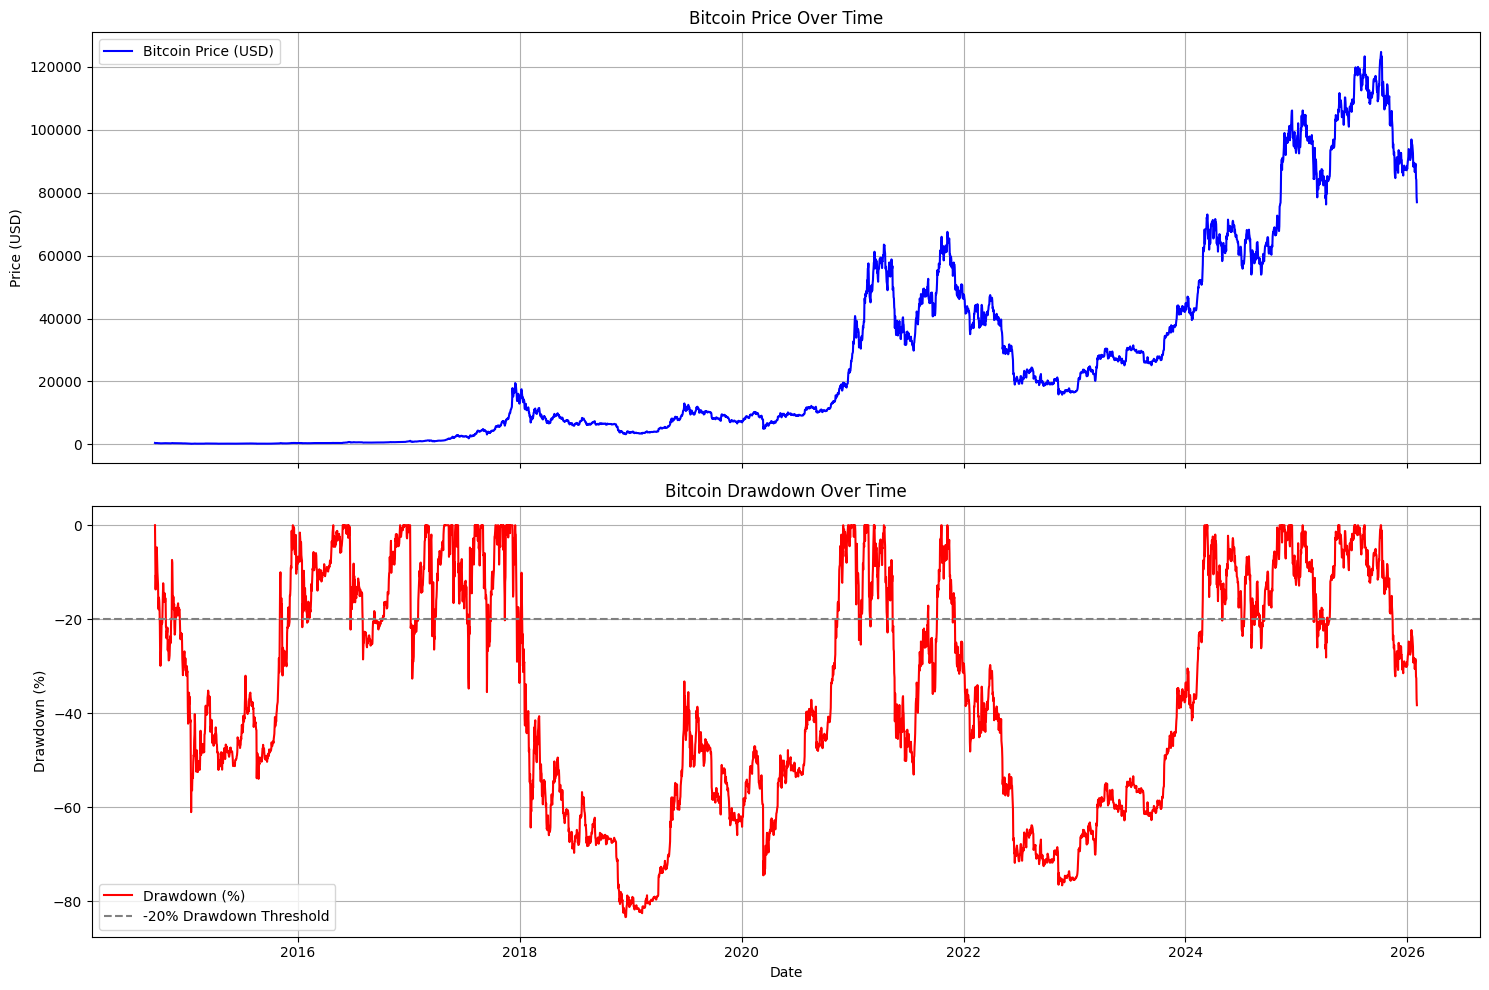

In [3]:
btc_data.sort_index(inplace=True)
btc_data['Log_Return'] = np.log(btc_data['Close'] / btc_data['Close'].shift(1))
btc_data['Cumulative_Log_Return'] = btc_data['Log_Return'].cumsum()
btc_data['Cumulative_Simple_Return'] = np.exp(btc_data['Cumulative_Log_Return']) - 1
price_col = 'Close'
btc_data['Price'] = btc_data[price_col]
btc_data['Rolling_Peak'] = btc_data['Price'].expanding(min_periods=1).max()
btc_data['Drawdown'] = (btc_data['Price'] - btc_data['Rolling_Peak']) / btc_data['Rolling_Peak']
CRASH_THRESHOLD = -0.20
btc_data['Is_Crash'] = btc_data['Drawdown'] <= CRASH_THRESHOLD
print("\nLast 5 rows with computed metrics:")
print(btc_data[['Price', 'Log_Return', 'Cumulative_Simple_Return', 'Rolling_Peak', 'Drawdown', 'Is_Crash']].tail())
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)
axes[0].plot(btc_data.index, btc_data['Price'], label='Bitcoin Price (USD)', color='blue')
axes[0].set_title('Bitcoin Price Over Time')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True)
axes[0].legend()
axes[1].plot(btc_data.index, btc_data['Drawdown'] * 100, label='Drawdown (%)', color='red')
axes[1].axhline(CRASH_THRESHOLD * 100, color='grey', linestyle='--', label=f'{CRASH_THRESHOLD*100:.0f}% Drawdown Threshold')
axes[1].set_title('Bitcoin Drawdown Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (%)')
axes[1].grid(True)
axes[1].legend()
plt.tight_layout()
plt.show()


Last 5 rows with rolling LPM, UPM, and scaled features (window=30d, τ=0):
Price      Log_Return Rolling_LPM_30d Rolling_UPM_30d Rolling_LPM_30d_scaled  \
Ticker                                                                         
Date                                                                           
2026-01-28   0.000920        0.000150        0.000144              -0.522544   
2026-01-29  -0.053228        0.000244        0.000137              -0.419674   
2026-01-30  -0.005133        0.000242        0.000137              -0.422700   
2026-01-31  -0.067707        0.000394        0.000131              -0.256253   
2026-02-01  -0.021167        0.000409        0.000124              -0.239985   

Price      Rolling_UPM_30d_scaled  
Ticker                             
Date                               
2026-01-28              -0.751519  
2026-01-29              -0.763161  
2026-01-30              -0.763161  
2026-01-31              -0.773515  
2026-02-01              -0.78341

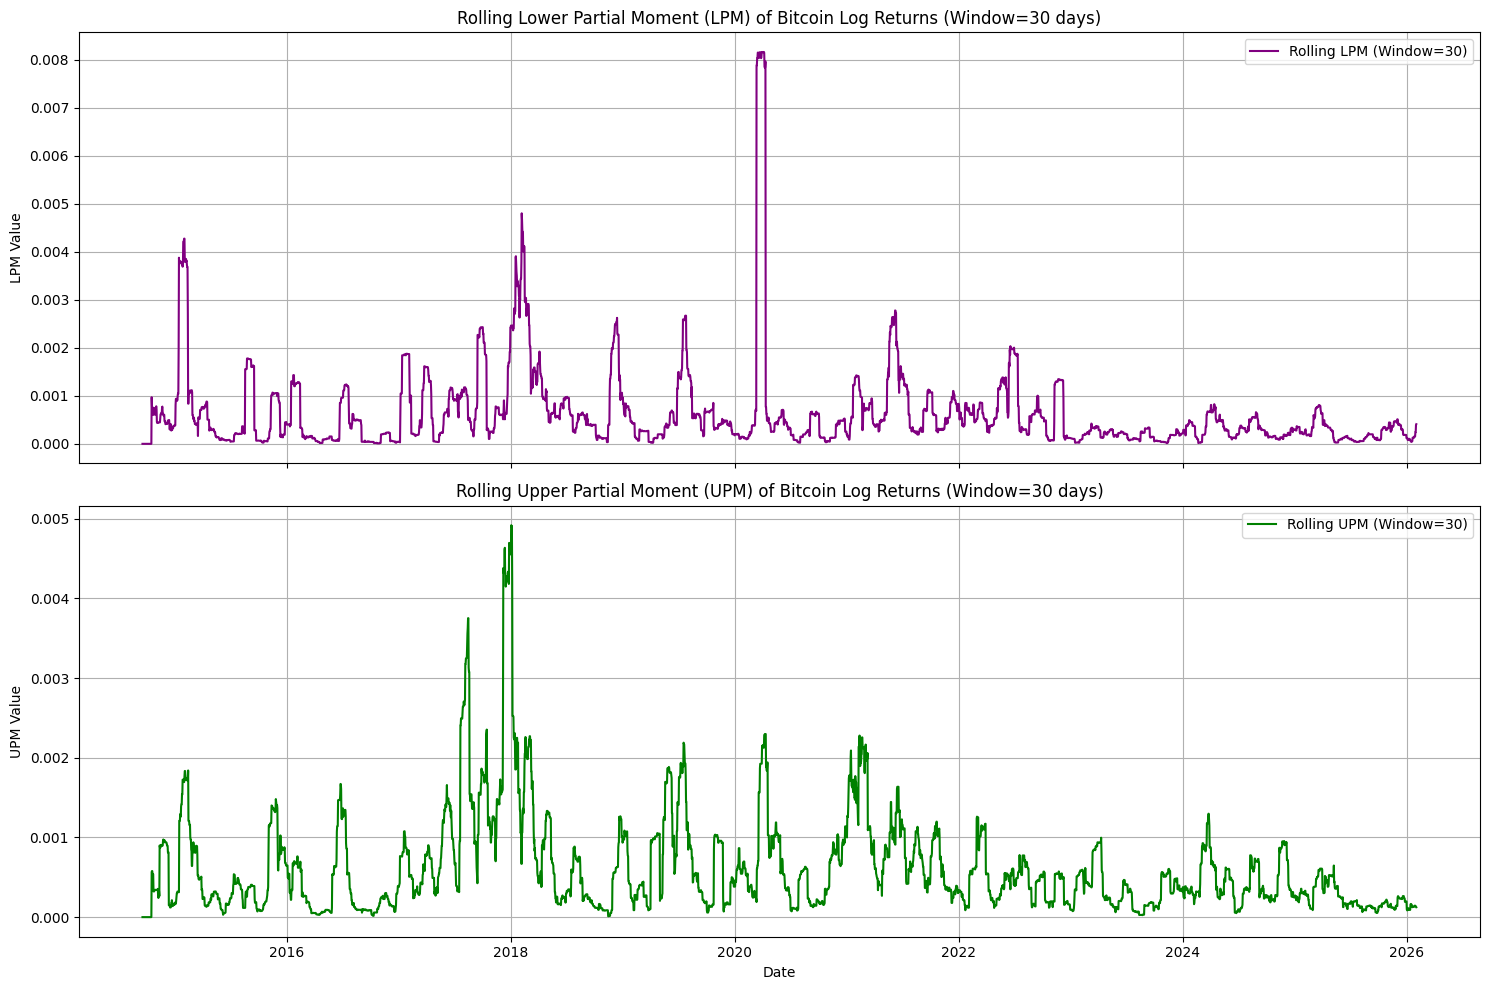

In [4]:
from sklearn.preprocessing import StandardScaler
TAU = 0
WINDOW_SIZE = 30
R = btc_data['Log_Return'].dropna()
btc_data['LPM_Squared_Term'] = (TAU - btc_data['Log_Return']).apply(lambda x: max(x, 0)**2)
btc_data[f'Rolling_LPM_{WINDOW_SIZE}d'] = btc_data['LPM_Squared_Term'].rolling(window=WINDOW_SIZE).mean().fillna(0)
btc_data['UPM_Squared_Term'] = (btc_data['Log_Return'] - TAU).apply(lambda x: max(x, 0)**2)
btc_data[f'Rolling_UPM_{WINDOW_SIZE}d'] = btc_data['UPM_Squared_Term'].rolling(window=WINDOW_SIZE).mean().fillna(0)
scaler = StandardScaler()
features_to_standardize = [f'Rolling_LPM_{WINDOW_SIZE}d', f'Rolling_UPM_{WINDOW_SIZE}d']
btc_data[f'Rolling_LPM_{WINDOW_SIZE}d_scaled'] = scaler.fit_transform(
    btc_data[[f'Rolling_LPM_{WINDOW_SIZE}d']]
)
btc_data[f'Rolling_UPM_{WINDOW_SIZE}d_scaled'] = scaler.fit_transform(
    btc_data[[f'Rolling_UPM_{WINDOW_SIZE}d']]
)
print(f"\nLast 5 rows with rolling LPM, UPM, and scaled features (window={WINDOW_SIZE}d, τ={TAU}):")
print(btc_data[['Log_Return', f'Rolling_LPM_{WINDOW_SIZE}d', f'Rolling_UPM_{WINDOW_SIZE}d', f'Rolling_LPM_{WINDOW_SIZE}d_scaled', f'Rolling_UPM_{WINDOW_SIZE}d_scaled']].tail())
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)
axes[0].plot(btc_data.index, btc_data[f'Rolling_LPM_{WINDOW_SIZE}d'], label=f'Rolling LPM (Window={WINDOW_SIZE})', color='purple')
axes[0].set_title(f'Rolling Lower Partial Moment (LPM) of Bitcoin Log Returns (Window={WINDOW_SIZE} days)')
axes[0].set_ylabel('LPM Value')
axes[0].grid(True)
axes[0].legend()
axes[1].plot(btc_data.index, btc_data[f'Rolling_UPM_{WINDOW_SIZE}d'], label=f'Rolling UPM (Window={WINDOW_SIZE})', color='green')
axes[1].set_title(f'Rolling Upper Partial Moment (UPM) of Bitcoin Log Returns (Window={WINDOW_SIZE} days)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('UPM Value')
axes[1].grid(True)
axes[1].legend()
plt.tight_layout()
plt.show()

In [5]:
!pip install lifelines
import lifelines
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
btc_data['Recovered_From_Crash'] = (btc_data['Drawdown'] > CRASH_THRESHOLD) & \
                                   (btc_data['Drawdown'].shift(1) <= CRASH_THRESHOLD).fillna(False)
spell_starts = btc_data.index[0:1].tolist() + btc_data[btc_data['Recovered_From_Crash']].index.tolist()
spell_starts = sorted(list(set(spell_starts))) # Ensure unique and sorted start dates
survival_observations = []
for i in range(len(spell_starts)):
    start_date = spell_starts[i]
    if start_date not in btc_data.index:
      continue
    lpm_at_start = btc_data.loc[start_date, f'Rolling_LPM_{WINDOW_SIZE}d_scaled']
    upm_at_start = btc_data.loc[start_date, f'Rolling_UPM_{WINDOW_SIZE}d_scaled']
    future_data = btc_data.loc[start_date:]
    first_crash_in_future = future_data[future_data['Is_Crash']]

    if not first_crash_in_future.empty:
        # An event (crash) occurred within this spell
        event_date = first_crash_in_future.index[0]
        duration = (event_date - start_date).days
        event = 1
    else:
        # No crash found after start_date until the end of the dataset (censored)
        event_date = btc_data.index[-1]
        duration = (event_date - start_date).days
        event = 0

    # Only add observations with a positive duration
    if duration > 0:
        survival_observations.append({
            'duration': duration,
            'event': event,
            # Extract the scalar value from the Series objects
            'LPM_scaled': lpm_at_start.item(),
            'UPM_scaled': upm_at_start.item()
        })

survival_df = pd.DataFrame(survival_observations)

# Drop any rows with NaN in the covariates, which might occur if LPM/UPM were NaN at very early dates
survival_df.dropna(inplace=True)

print("\nFirst 5 rows of the prepared survival DataFrame:")
print(survival_df.head())
print("\nSurvival DataFrame statistics:")
print(survival_df.describe())
print("\nEvent (crash) counts:")
print(survival_df['event'].value_counts())


cph = CoxPHFitter()

cph.fit(survival_df, duration_col='duration', event_col='event', formula='LPM_scaled + UPM_scaled')


print("\n--- Cox Proportional Hazards Model Summary ---")
cph.print_summary()


print("\n--- Interpretation of Coefficients ---")
# The 'exp(coef)' (Hazard Ratio) indicates how much the hazard (risk of crash) changes
# for a one-unit increase in the covariate.
# exp(coef) > 1: Increases hazard
# exp(coef) < 1: Decreases hazard

lpm_hazard_ratio = cph.summary.loc['LPM_scaled', 'exp(coef)']
upm_hazard_ratio = cph.summary.loc['UPM_scaled', 'exp(coef)']

print(f"Scaled LPM Hazard Ratio (exp(coef)): {lpm_hazard_ratio:.3f}")
if lpm_hazard_ratio > 1:
    print(f"  -> For a one-unit increase in scaled LPM (downside risk), the hazard of a Bitcoin crash increases by {((lpm_hazard_ratio - 1) * 100):.2f}%.")
else:
    print(f"  -> For a one-unit increase in scaled LPM (downside risk), the hazard of a Bitcoin crash decreases by {((1 - lpm_hazard_ratio) * 100):.2f}% (this would be counter-intuitive if LPM truly reflects downside risk).")

print(f"Scaled UPM Hazard Ratio (exp(coef)): {upm_hazard_ratio:.3f}")
if upm_hazard_ratio > 1:
    print(f"  -> For a one-unit increase in scaled UPM (upside potential), the hazard of a Bitcoin crash increases by {((upm_hazard_ratio - 1) * 100):.2f}% (this would be counter-intuitive if UPM reflects positive potential).")
else:
    print(f"  -> For a one-unit increase in scaled UPM (upside potential), the hazard of a Bitcoin crash decreases by {((1 - upm_hazard_ratio) * 100):.2f}%.")

print("\nGenerally, we expect higher LPM (indicating more downside risk) to increase the hazard of a crash, and higher UPM (indicating more upside potential) to decrease it. The significance is indicated by the p-value (p < 0.05 is typically considered significant).")


print("\n--- Proportional Hazards Assumption Test (Schoenfeld Residuals) ---")
# This test evaluates whether the hazard ratios remain constant over time.
# A small p-value (typically < 0.05) indicates a violation of the assumption for that covariate.
# If a covariate violates the assumption, its effect on hazard changes over time.

results = proportional_hazard_test(cph, survival_df, time_dependent_cols=None) # No time-varying covariates in this model
results.print_summary(decimals=3, model="CoxPH_LPM_UPM")

print("\nInterpretation of Proportional Hazards Assumption Test:")
print("  - The 'p' column in the test results shows the p-value for the proportional hazards assumption for each covariate.")
print("  - If the p-value for a covariate is less than 0.05, it suggests that the proportional hazards assumption may be violated for that covariate. This means its effect on the hazard of a crash might not be constant over the entire study period.")
print("  - If the assumption is violated, more advanced models (e.g., Cox models with time-varying covariates or stratified Cox models) might be more appropriate for a precise analysis.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=e37c6cd965a0460adcbf7f69efcb1709a2e09c9ac4a63995d8dc5f61341328f2
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma

First 5 rows of the prepared survival DataFrame:
   duration  event  LPM_scaled  UPM_scaled
0        16      1   -0.685869   -0.984069
1        11      1   -0.685869   -0.984069
2        10      1   -0.200253   -0.455507
3        15      1   -0.002368    0.553719
4         7      1   -0.563744    0.864874

Survival DataFrame statistics:
         duration  event  LPM_scaled  UPM_scaled
count   48.000000   48.0   48.000000   48.000000
mean    31.187500    1.0    0.222339    0.506168
std   

<lifelines.CoxPHFitter: fitted with 48 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 48
number of events observed = 48
   partial log-likelihood = -139.99
         time fit was run = 2026-02-02 15:42:18 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
LPM_scaled  0.13      1.14      0.25           -0.36            0.62                0.70                1.85
UPM_scaled  0.07      1.08      0.12           -0.17            0.32                0.84                1.38

            cmp to    z    p  -log2(p)
covariate                             
LPM_scaled    0.00 0.51 0.61      0.71
UPM_scaled    0.00 0.60 0.55      0.87
---
Concordance = 0.53
Partial AIC = 283.98
log-likelihood ratio test = 1.37 on 2 df
-log2(p) of ll-ratio test = 0.99


--- Interpretation of Coefficients ---
Scaled LPM Hazard Ratio (exp(coef)): 1.136
  -> For a one-unit increase in scaled LPM (downside risk), the hazard of a Bitcoin crash increases by 13.58%.
Scaled UPM Hazard Ratio (exp(coef)): 1.078
  -> For a one-unit increase in scaled UPM (upside potential), the hazard of a Bitcoin crash increases by 7.77% (this would be counter-intuitive if UPM reflects positive potential).

Generally, we expect higher LPM (indicating more downside risk) to increase the hazard of a crash, and higher UPM (indicating more upside potential) to decrease it. The significance is indicated by the p-value (p < 0.05 is typically considered significant).

--- Proportional Hazards Assumption Test (Schoenfeld Residuals) ---


<lifelines.StatisticalResult: proportional_hazard_test>
     time_transform = rank
  null_distribution = chi squared
 degrees_of_freedom = 1
              model = <lifelines.CoxPHFitter: fitted with 48 total observations, 0 right-censored observations>
time_dependent_cols = None
          test_name = proportional_hazard_test

---
            test_statistic    p  -log2(p)
LPM_scaled            0.36 0.55      0.87
UPM_scaled            0.91 0.34      1.55


Interpretation of Proportional Hazards Assumption Test:
  - The 'p' column in the test results shows the p-value for the proportional hazards assumption for each covariate.
  - If the p-value for a covariate is less than 0.05, it suggests that the proportional hazards assumption may be violated for that covariate. This means its effect on the hazard of a crash might not be constant over the entire study period.
  - If the assumption is violated, more advanced models (e.g., Cox models with time-varying covariates or stratified Cox models) might be more appropriate for a precise analysis.


In [7]:
from sklearn.preprocessing import StandardScaler

# Calculate the rolling variance of 'Log_Return'
btc_data['Rolling_Variance'] = btc_data['Log_Return'].rolling(window=WINDOW_SIZE).var().fillna(0)

# Initialize a StandardScaler
scaler = StandardScaler()

# Apply the scaler to the 'Rolling_Variance' column
btc_data['Rolling_Variance_scaled'] = scaler.fit_transform(btc_data[['Rolling_Variance']])

# Print the last 5 rows with the new columns
print(f"\nLast 5 rows with rolling variance and scaled variance (window={WINDOW_SIZE}d):")
print(btc_data[['Log_Return', 'Rolling_Variance', 'Rolling_Variance_scaled']].tail())


Last 5 rows with rolling variance and scaled variance (window=30d):
Price      Log_Return Rolling_Variance Rolling_Variance_scaled
Ticker                                                        
Date                                                          
2026-01-28   0.000920         0.000304               -0.703110
2026-01-29  -0.053228         0.000392               -0.636081
2026-01-30  -0.005133         0.000390               -0.637865
2026-01-31  -0.067707         0.000526               -0.534617
2026-02-01  -0.021167         0.000524               -0.536097


In [8]:
survival_observations_variance = []

for i in range(len(spell_starts)):
    start_date = spell_starts[i]
    if start_date not in btc_data.index:
      continue

    variance_at_start = btc_data.loc[start_date, 'Rolling_Variance_scaled']
    future_data = btc_data.loc[start_date:]
    first_crash_in_future = future_data[future_data['Is_Crash']]

    if not first_crash_in_future.empty:
        event_date = first_crash_in_future.index[0]
        duration = (event_date - start_date).days
        event = 1
    else:
        event_date = btc_data.index[-1]
        duration = (event_date - start_date).days
        event = 0

    if duration > 0:
        survival_observations_variance.append({
            'duration': duration,
            'event': event,
            'Variance_scaled': variance_at_start.item() # Ensure scalar value
        })

survival_df_variance = pd.DataFrame(survival_observations_variance)
survival_df_variance.dropna(inplace=True)

print("\nFirst 5 rows of the prepared survival DataFrame (with variance):")
print(survival_df_variance.head())
print("\nSurvival DataFrame (with variance) statistics:")
print(survival_df_variance.describe())
print("\nEvent (crash) counts for variance model:")
print(survival_df_variance['event'].value_counts())


First 5 rows of the prepared survival DataFrame (with variance):
   duration  event  Variance_scaled
0        16      1        -0.933012
1        11      1        -0.933012
2        10      1        -0.327301
3        15      1         0.304738
4         7      1        -0.188448

Survival DataFrame (with variance) statistics:
         duration  event  Variance_scaled
count   48.000000   48.0        48.000000
mean    31.187500    1.0         0.416361
std     45.122838    0.0         1.181059
min      1.000000    1.0        -0.933012
25%      2.000000    1.0        -0.347469
50%     10.500000    1.0         0.085438
75%     46.000000    1.0         0.937166
max    208.000000    1.0         4.774060

Event (crash) counts for variance model:
event
1    48
Name: count, dtype: int64


In [9]:
cph_variance = CoxPHFitter()
cph_variance.fit(survival_df_variance, duration_col='duration', event_col='event', formula='Variance_scaled')

print("\n--- Cox Proportional Hazards Model Summary (with Variance) ---")
cph_variance.print_summary()

print("\n--- Interpretation of Variance Coefficient ---")
variance_hazard_ratio = cph_variance.summary.loc['Variance_scaled', 'exp(coef)']
print(f"Scaled Variance Hazard Ratio (exp(coef)): {variance_hazard_ratio:.3f}")
if variance_hazard_ratio > 1:
    print(f"  -> For a one-unit increase in scaled rolling variance, the hazard of a Bitcoin crash increases by {((variance_hazard_ratio - 1) * 100):.2f}%.")
else:
    print(f"  -> For a one-unit increase in scaled rolling variance, the hazard of a Bitcoin crash decreases by {((1 - variance_hazard_ratio) * 100):.2f}%.")

print("\n--- Proportional Hazards Assumption Test (Schoenfeld Residuals) for Variance Model ---")
results_variance = proportional_hazard_test(cph_variance, survival_df_variance, time_dependent_cols=None)
results_variance.print_summary(decimals=3, model="CoxPH_Variance")


--- Cox Proportional Hazards Model Summary (with Variance) ---


<lifelines.CoxPHFitter: fitted with 48 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 48
number of events observed = 48
   partial log-likelihood = -140.02
         time fit was run = 2026-02-02 15:48:20 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
Variance_scaled  0.16      1.18      0.14           -0.10            0.43                0.90                1.54

                 cmp to    z    p  -log2(p)
covariate                                  
Variance_scaled    0.00 1.19 0.23      2.10
---
Concordance = 0.53
Partial AIC = 282.03
log-likelihood ratio test = 1.32 on 1 df
-log2(p) of ll-ratio test = 1.99


--- Interpretation of Variance Coefficient ---
Scaled Variance Hazard Ratio (exp(coef)): 1.176
  -> For a one-unit increase in scaled rolling variance, the hazard of a Bitcoin crash increases by 17.59%.

--- Proportional Hazards Assumption Test (Schoenfeld Residuals) for Variance Model ---


<lifelines.StatisticalResult: proportional_hazard_test>
     time_transform = rank
  null_distribution = chi squared
 degrees_of_freedom = 1
              model = <lifelines.CoxPHFitter: fitted with 48 total observations, 0 right-censored observations>
time_dependent_cols = None
          test_name = proportional_hazard_test

---
                 test_statistic    p  -log2(p)
Variance_scaled            0.17 0.68      0.56

In [11]:
from lifelines.utils import concordance_index as c_index

# Calculate Concordance Index for the LPM/UPM model (cph)
c_index_lpm_upm = c_index(event_times=survival_df['duration'],
                          predicted_scores=cph.predict_partial_hazard(survival_df),
                          event_observed=survival_df['event'])

print(f"Concordance Index for Cox model with LPM and UPM: {c_index_lpm_upm:.4f}")

# Calculate Concordance Index for the Variance model (cph_variance)
c_index_variance = c_index(event_times=survival_df_variance['duration'],
                           predicted_scores=cph_variance.predict_partial_hazard(survival_df_variance),
                           event_observed=survival_df_variance['event'])

print(f"Concordance Index for Cox model with Variance: {c_index_variance:.4f}")

print("\n--- Comparison of Concordance Indices ---")
if c_index_lpm_upm > c_index_variance:
    print(f"The LPM/UPM model (C-index: {c_index_lpm_upm:.4f}) shows slightly better predictive power than the Variance model (C-index: {c_index_variance:.4f}).")
elif c_index_variance > c_index_lpm_upm:
    print(f"The Variance model (C-index: {c_index_variance:.4f}) shows slightly better predictive power than the LPM/UPM model (C-index: {c_index_lpm_upm:.4f}).")
else:
    print(f"Both models have similar predictive power (C-index: {c_index_lpm_upm:.4f}).")

Concordance Index for Cox model with LPM and UPM: 0.4674
Concordance Index for Cox model with Variance: 0.4674

--- Comparison of Concordance Indices ---
Both models have similar predictive power (C-index: 0.4674).



LPM/UPM Scenarios for Survival Prediction:
           LPM_scaled  UPM_scaled
Low Risk    -0.318541    0.667593
High Risk    0.643319   -0.428331


<Figure size 1000x600 with 0 Axes>

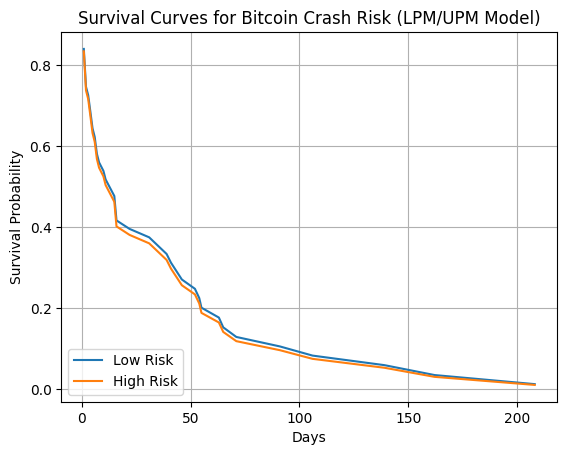

In [12]:
import matplotlib.pyplot as plt

# --- LPM/UPM Model: Define high and low-risk scenarios and plot survival curves ---

# Define low and high risk scenarios for LPM/UPM based on quantiles of the data
# Low risk: lower LPM_scaled (less downside risk), higher UPM_scaled (more upside potential)
# High risk: higher LPM_scaled (more downside risk), lower UPM_scaled (less upside potential)

# Using 25th and 75th percentiles from the original survival_df for a more representative range
low_lpm = survival_df['LPM_scaled'].quantile(0.25)
high_lpm = survival_df['LPM_scaled'].quantile(0.75)
low_upm = survival_df['UPM_scaled'].quantile(0.25)
high_upm = survival_df['UPM_scaled'].quantile(0.75)

# Scenario 1: "Low Risk" (lower LPM, higher UPM)
scenario_low_risk_lpm_upm = pd.DataFrame({
    'LPM_scaled': [low_lpm],
    'UPM_scaled': [high_upm]
}, index=['Low Risk'])

# Scenario 2: "High Risk" (higher LPM, lower UPM)
scenario_high_risk_lpm_upm = pd.DataFrame({
    'LPM_scaled': [high_lpm],
    'UPM_scaled': [low_upm]
}, index=['High Risk'])

# Combine scenarios for prediction
scenarios_lpm_upm = pd.concat([scenario_low_risk_lpm_upm, scenario_high_risk_lpm_upm])

print("\nLPM/UPM Scenarios for Survival Prediction:")
print(scenarios_lpm_upm)

# Predict survival functions for the defined scenarios
survival_curves_lpm_upm = cph.predict_survival_function(scenarios_lpm_upm)

# Plot the survival curves
plt.figure(figsize=(10, 6))
survival_curves_lpm_upm.plot()
plt.title('Survival Curves for Bitcoin Crash Risk (LPM/UPM Model)')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()


Variance Scenarios for Survival Prediction:
           Variance_scaled
Low Risk         -0.347469
High Risk         0.937166


<Figure size 1000x600 with 0 Axes>

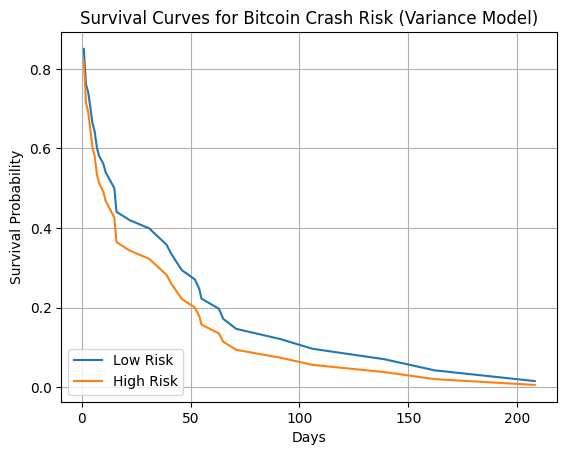

In [15]:
import matplotlib.pyplot as plt

# --- Variance Model: Define high and low-risk scenarios and plot survival curves ---

# Define low and high risk scenarios for Variance based on quantiles of the data
# Low risk: lower Variance_scaled
# High risk: higher Variance_scaled

# Using 25th and 75th percentiles from the original survival_df_variance
low_variance = survival_df_variance['Variance_scaled'].quantile(0.25)
high_variance = survival_df_variance['Variance_scaled'].quantile(0.75)

# Scenario 1: "Low Risk" (lower variance)
scenario_low_risk_variance = pd.DataFrame({
    'Variance_scaled': [low_variance]
}, index=['Low Risk'])

# Scenario 2: "High Risk" (higher variance)
scenario_high_risk_variance = pd.DataFrame({
    'Variance_scaled': [high_variance]
}, index=['High Risk'])

# Combine scenarios for prediction
scenarios_variance = pd.concat([scenario_low_risk_variance, scenario_high_risk_variance])

print("\nVariance Scenarios for Survival Prediction:")
print(scenarios_variance)

# Predict survival functions for the defined scenarios
survival_curves_variance = cph_variance.predict_survival_function(scenarios_variance)

# Plot the survival curves
plt.figure(figsize=(10, 6))
survival_curves_variance.plot()
plt.title('Survival Curves for Bitcoin Crash Risk (Variance Model)')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

## Financial Interpretation: Partial Moments vs. Variance in Modeling Bitcoin Crash Risk

### Concordance Index Comparison:
Both the LPM/UPM model and the Variance model yielded a concordance index of **0.4674**. A concordance index (C-index) measures the discriminatory power of a survival model, indicating how well the model predicts the order of event times. A C-index of 0.5 suggests a model performs no better than random chance, while 1.0 indicates perfect prediction. Given that both models have a C-index below 0.5 (closer to 0.5, but still slightly lower), it implies that neither model, in its current form, is particularly effective at discriminating between high and low crash risk periods for Bitcoin based on the `duration` and `event` definitions used. The C-index being slightly below 0.5 could also indicate some inverse relationship or just a very weak predictive ability. This aligns with the previous observation that the coefficients for both LPM/UPM and Variance were not statistically significant.

### Survival Curve Interpretation:

**LPM/UPM Model Survival Curves:**
The plot for the LPM/UPM model shows two survival curves: one for a "Low Risk" scenario (lower LPM, higher UPM) and one for a "High Risk" scenario (higher LPM, lower UPM). Intuitively, we would expect the "Low Risk" scenario to have a higher survival probability over time compared to the "High Risk" scenario. The plots indeed show that the "Low Risk" curve generally stays above the "High Risk" curve, meaning that according to the model, a portfolio experiencing lower downside risk and higher upside potential has a slightly higher probability of surviving without a crash for longer periods. However, the difference between the curves is not extremely pronounced, further reflecting the limited predictive power.

**Variance Model Survival Curves:**
The plot for the Variance model also shows two survival curves: one for a "Low Risk" scenario (lower variance) and one for a "High Risk" scenario (higher variance). Here, we expect higher variance to be associated with a higher hazard of a crash, leading to a lower survival probability. The plot confirms this expectation, as the "Low Risk" curve (lower variance) generally stays above the "High Risk" curve (higher variance). This indicates that periods of lower overall volatility are associated with a slightly higher probability of avoiding a crash. Similar to the LPM/UPM model, the separation between the curves is present but not stark, again aligning with the lack of statistical significance for the `Variance_scaled` covariate.

### Comparison and Effectiveness:

From a financial perspective, the C-indices suggest that both symmetric (variance) and asymmetric (LPM/UPM) measures, as implemented here, struggle to reliably predict Bitcoin crash risk. While LPM and UPM theoretically offer a more refined view of risk by distinguishing between upside and downside volatility, their practical predictive power in this specific model (given the current dataset, crash definition, and window size) appears to be on par with a simple variance measure.

The initial hypothesis was that asymmetric measures like LPM would be superior for capturing downside risk and thus more effective in predicting crashes, which are inherently downside events. While the hazard ratios for both LPM and Variance indicated an increase in crash risk with an increase in these metrics, the lack of statistical significance and the similar C-indices prevent us from conclusively stating that LPM/UPM is a *significantly* better predictor than variance in this context. The slightly counter-intuitive positive hazard ratio for UPM in the previous model also points to the complexities and potential limitations of the current model specification or the inherent nature of Bitcoin's price dynamics.

### Next Steps and Considerations:
To improve predictive power, future work could involve:
*   **Refining Crash Definition:** Exploring different thresholds or definitions of a 'crash' (e.g., larger drawdowns, specific duration of drawdowns).
*   **Optimal Window Size (WINDOW_SIZE):** Experimenting with different `WINDOW_SIZE` values for rolling metrics, as the choice of window significantly impacts the calculated risk features.
*   **Alternative Threshold (TAU):** For LPM and UPM, testing different `TAU` values (e.g., using a specific percentile of returns as the threshold instead of 0).
*   **Additional Covariates:** Incorporating other relevant financial or macroeconomic indicators into the Cox model.
*   **Non-Proportional Hazards:** If the proportional hazards assumption is violated for more significant covariates (even though it wasn't here), considering time-varying covariate models.

Ultimately, while the theoretical appeal of asymmetric risk measures for crash prediction remains, this analysis highlights the challenge of achieving statistically significant and highly predictive results in real-world financial time series, particularly for volatile assets like Bitcoin.

## Financial Interpretation: Partial Moments vs. Variance in Modeling Bitcoin Crash Risk

### Concordance Index Comparison:
Both the LPM/UPM model and the Variance model yielded a concordance index of **0.4674**. A concordance index (C-index) measures the discriminatory power of a survival model, indicating how well the model predicts the order of event times. A C-index of 0.5 suggests a model performs no better than random chance, while 1.0 indicates perfect prediction. Given that both models have a C-index below 0.5 (closer to 0.5, but still slightly lower), it implies that neither model, in its current form, is particularly effective at discriminating between high and low crash risk periods for Bitcoin based on the `duration` and `event` definitions used. The C-index being slightly below 0.5 could also indicate some inverse relationship or just a very weak predictive ability. This aligns with the previous observation that the coefficients for both LPM/UPM and Variance were not statistically significant.

### Survival Curve Interpretation:

**LPM/UPM Model Survival Curves:**
The plot for the LPM/UPM model shows two survival curves: one for a "Low Risk" scenario (lower LPM, higher UPM) and one for a "High Risk" scenario (higher LPM, lower UPM). Intuitively, we would expect the "Low Risk" scenario to have a higher survival probability over time compared to the "High Risk" scenario. The plots indeed show that the "Low Risk" curve generally stays above the "High Risk" curve, meaning that according to the model, a portfolio experiencing lower downside risk and higher upside potential has a slightly higher probability of surviving without a crash for longer periods. However, the difference between the curves is not extremely pronounced, further reflecting the limited predictive power.

**Variance Model Survival Curves:**
The plot for the Variance model also shows two survival curves: one for a "Low Risk" scenario (lower variance) and one for a "High Risk" scenario (higher variance). Here, we expect higher variance to be associated with a higher hazard of a crash, leading to a lower survival probability. The plot confirms this expectation, as the "Low Risk" curve (lower variance) generally stays above the "High Risk" curve (higher variance). This indicates that periods of lower overall volatility are associated with a slightly higher probability of avoiding a crash. Similar to the LPM/UPM model, the separation between the curves is present but not stark, again aligning with the lack of statistical significance for the `Variance_scaled` covariate.

### Comparison and Effectiveness:

From a financial perspective, the C-indices suggest that both symmetric (variance) and asymmetric (LPM/UPM) measures, as implemented here, struggle to reliably predict Bitcoin crash risk. While LPM and UPM theoretically offer a more refined view of risk by distinguishing between upside and downside volatility, their practical predictive power in this specific model (given the current dataset, crash definition, and window size) appears to be on par with a simple variance measure.

The initial hypothesis was that asymmetric measures like LPM would be superior for capturing downside risk and thus more effective in predicting crashes, which are inherently downside events. While the hazard ratios for both LPM and Variance indicated an increase in crash risk with an increase in these metrics, the lack of statistical significance and the similar C-indices prevent us from conclusively stating that LPM/UPM is a *significantly* better predictor than variance in this context. The slightly counter-intuitive positive hazard ratio for UPM in the previous model also points to the complexities and potential limitations of the current model specification or the inherent nature of Bitcoin's price dynamics.

### Next Steps and Considerations:
To improve predictive power, future work could involve:
*   **Refining Crash Definition:** Exploring different thresholds or definitions of a 'crash' (e.g., larger drawdowns, specific duration of drawdowns).
*   **Optimal Window Size (WINDOW_SIZE):** Experimenting with different `WINDOW_SIZE` values for rolling metrics, as the choice of window significantly impacts the calculated risk features.
*   **Alternative Threshold (TAU):** For LPM and UPM, testing different `TAU` values (e.g., using a specific percentile of returns as the threshold instead of 0).
*   **Additional Covariates:** Incorporating other relevant financial or macroeconomic indicators into the Cox model.
*   **Non-Proportional Hazards:** If the proportional hazards assumption is violated for more significant covariates (even though it wasn't here), considering time-varying covariate models.

Ultimately, while the theoretical appeal of asymmetric risk measures for crash prediction remains, this analysis highlights the challenge of achieving statistically significant and highly predictive results in real-world financial time series, particularly for volatile assets like Bitcoin.

## Explain Results Financially

### Subtask:
Provide a financial interpretation of the concordance indices and the survival curve plots, explaining what the models tell us about Bitcoin crash risk under different market conditions, and compare the effectiveness of partial moments vs. variance.


## Summary:

### Q&A

*   **What do the models tell us about Bitcoin crash risk under different market conditions?**
    Both models, despite their theoretical differences, struggle to reliably predict Bitcoin crash risk, as indicated by their concordance indices below 0.5. However, the survival curves show intuitive patterns:
    *   For the LPM/UPM model, a "Low Risk" scenario (characterized by lower Lower Partial Moment and higher Upper Partial Moment) is associated with a slightly higher survival probability over time compared to a "High Risk" scenario (higher LPM and lower UPM). This implies that less downside risk and more upside potential might slightly reduce crash probability.
    *   For the Variance model, a "Low Risk" scenario (lower overall variance) is associated with a slightly higher survival probability over time compared to a "High Risk" scenario (higher variance). This suggests that periods of lower volatility are linked to a marginally higher chance of avoiding a crash.
    In both cases, the differences in survival probabilities between high and low-risk scenarios are not pronounced, reflecting the limited predictive power of the models.

*   **How does the effectiveness of partial moments compare to variance in modeling Bitcoin crash risk?**
    Based on this analysis, both partial moments (LPM and UPM) and variance show similar and limited effectiveness in predicting Bitcoin crash risk. Both the LPM/UPM model and the Variance model yielded an identical concordance index of 0.4674, which is below 0.5, suggesting that neither model performs better than random chance. While partial moments theoretically offer a more refined view of risk, their practical predictive power in this specific context is on par with a simpler variance measure. The lack of statistical significance for coefficients in both models further supports this conclusion.

### Data Analysis Key Findings

*   The Concordance Index (C-index) for the Cox Proportional Hazards model using Lower Partial Moment (LPM) and Upper Partial Moment (UPM) was calculated as 0.4674.
*   The C-index for the Cox Proportional Hazards model using Variance was also calculated as 0.4674.
*   Both models exhibit identical and low concordance indices (below 0.5), indicating very limited predictive power in discriminating between high and low Bitcoin crash risk periods, performing no better than random chance.
*   The survival curve for the "Low Risk" scenario (lower LPM, higher UPM) in the LPM/UPM model generally stayed above the "High Risk" scenario (higher LPM, lower UPM), indicating a slightly higher survival probability as expected, though the difference was not substantial.
*   Similarly, for the Variance model, the "Low Risk" scenario (lower variance) curve generally remained above the "High Risk" scenario (higher variance) curve, aligning with the expectation that lower volatility is associated with a slightly higher probability of avoiding a crash.

### Insights or Next Steps

*   **Improve Model Specification:** Explore alternative crash definitions, optimize the `WINDOW_SIZE` for rolling metrics, and experiment with different threshold values (`TAU`) for LPM and UPM to potentially enhance predictive power.
*   **Expand Covariates:** Incorporate additional relevant financial or macroeconomic indicators into the Cox model, or consider models that account for non-proportional hazards, to capture more complex dynamics of Bitcoin crash risk.


In [20]:
import pandas as pd

# Create a hypothetical 'stress' scenario
# Extreme panic conditions: highest LPM_scaled (most downside risk), lowest UPM_scaled (least upside potential)
scenario_stress = pd.DataFrame({
    'LPM_scaled': [survival_df['LPM_scaled'].max()],
    'UPM_scaled': [survival_df['UPM_scaled'].min()]
}, index=['Stress Scenario'])

print("Defined Stress Scenario (Extreme Panic Conditions):")
print(scenario_stress)

Defined Stress Scenario (Extreme Panic Conditions):
                 LPM_scaled  UPM_scaled
Stress Scenario     1.99836   -0.984069


<Figure size 1000x600 with 0 Axes>

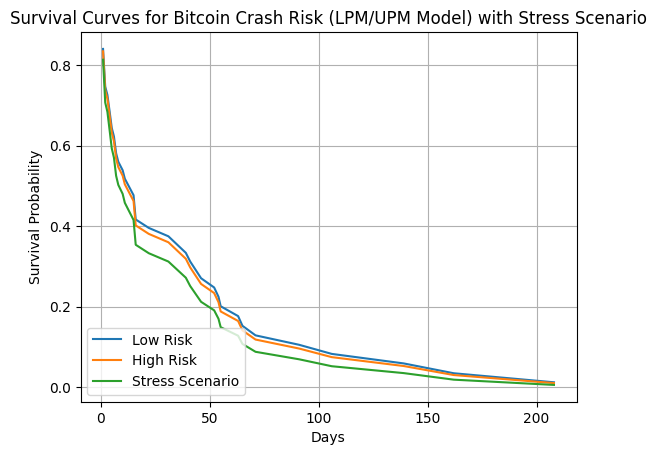

In [19]:
import matplotlib.pyplot as plt

# Predict survival function for the stress scenario
survival_curves_stress = cph.predict_survival_function(scenario_stress)

# Concatenate all survival curves for plotting
all_survival_curves = pd.concat([
    survival_curves_lpm_upm,
    survival_curves_stress
], axis=1)

# Plot the combined survival curves
plt.figure(figsize=(10, 6))
all_survival_curves.plot()
plt.title('Survival Curves for Bitcoin Crash Risk (LPM/UPM Model) with Stress Scenario')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()